In [32]:
import cv2
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve

In [2]:
# resize the imaghe proportionally

def img_resize(image, new_cols):
    row, col = image.shape[0], image.shape[1]
    
    ridio = new_cols / col
    
    new_rows = ridio * row
    
    img_new = cv2.resize(image, (int(new_cols), int(new_rows)))
    return img_new

In [3]:
# def normalization_e(data):
#     _range = np.max(data) - np.min(data)
#     return (data - np.min(data)) / _range

In [4]:
# compute gradient of image

def compute_sobel(im):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    im = im.astype('float32')
    convolved = np.absolute(convolve(im, filter_du)) + np.absolute(convolve(im, filter_dv))
    return convolved

In [5]:
# compute gradient of image and construct energy image

def compute_importance(image):
    eI = compute_sobel(image)  
    return eI

In [6]:
# compute the accumulation of energy

def compute_M(importances):
    [row, column] = importances.shape
    M = np.zeros((row, column))
    track = np.zeros((row, column))
    
    for i in range(row):
        for j in range(column):
            if (i == 0):
                M[i][j] = importances[i][j]
                track[i][j] = 0
            else:
                if (j == 0):
                    M[i][j] = importances[i][j] + np.min(M[i - 1, j: j + 2])
                    track[i][j] = j + np.argmin(M[i - 1, j: j + 2])
                elif (j == column - 1):
                    M[i][j] = importances[i][j] + np.min(M[i - 1, j - 1: j + 1])
                    track[i][j] = j - 1 + np.argmin(M[i - 1, j - 1: j + 1])
                else:
                    M[i][j] = importances[i][j] + np.min(M[i - 1, j - 1 : j + 2])
                    track[i][j] = j - 1 + np.argmin(M[i - 1, j - 1: j + 2])
    return M, track

In [7]:
# delete a column path

def delete_column(img):
    image = img.copy()
    im = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    [row, column, channel] = image.shape
    mask = np.ones((row, column), dtype=np.bool)
    
    importances = compute_importance(im)
    [M, btrack] = compute_M(importances)
    
    pos = np.argmin(M[row - 1, :])
    mask_im = image.copy()
    for i in reversed(range(row)):
        mask[i, pos] = 0
        pos = int(btrack[i, pos])
        mask_im[i, pos] = 255
        
    mask = np.stack([mask] * 3, axis=2)

    image = image[mask].reshape((row, column - 1, channel))
        
#     plt.imshow(mask_im)
    return image

In [8]:
# crop the image to new size

def crop_image(im, newrow, newcol):
    image = im.copy()
    [row, col, channel] = image.shape
    crop_row_times = row - newrow
    crop_col_times = col - newcol
    for i in range(crop_col_times):
#         print(i)
        image = delete_column(image)
    
    image = np.rot90(image, 1, (0, 1))
    for i in range(crop_row_times):
#         print(i)
        image = delete_column(image)
    image = np.rot90(image, 3, (0, 1))
    return image

In [9]:
# retarget the image to new size

def retarget_image(im, newrow, newcol):
    image = im.copy()
    [row, col, channel] = image.shape
    row_radio = row / newrow
    col_radio = col / newcol
    print (row_radio, col_radio)
    if (newrow > row and newcol > col):
        if (row_radio < col_radio):
            thecol = int(col / row_radio)
            image = img_resize(image, thecol)
        else:
            image = img_resize(image, newcol)
    elif (newrow > row and newcol <= col):
        thecol = int(col / row_radio)
        image = img_resize(image, thecol)
    elif (newrow <= row and newcol > col):
        image = img_resize(image, newcol)
    
    print (image.shape)
    image = crop_image(image, newrow, newcol)
    return image

In [10]:
# remove a column path of the signned rect

def remove_line(img, a, b, c ,d):
    im = img.copy()
    image = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    
    [row, column, channel] = im.shape
    mask = np.ones((row, column), dtype=np.bool)
    
    importances = compute_importance(image)
    for i in range(b - a):
        for j in range(d - c):
            importances[i + a][j + c] = -100000
    [M, btrack] = compute_M(importances)
#     plt.imshow(M, cmap = plt.cm.gray)
    
    pos = np.argmin(M[row - 1, :])
    mask_im = image.copy()
    for i in reversed(range(row)):
        mask[i, pos] = 0
        pos = int(btrack[i, pos])
        mask_im[i, pos] = 255
        
    mask = np.stack([mask] * 3, axis=2)

    im = im[mask].reshape((row, column - 1, channel))
#     plt.imshow(im, cmap = plt.cm.gray)
    return im

In [11]:
# remove the signned rect vertically

def remove_rect(im, a, b, c ,d):
    image = im.copy()
    m  = d
    for i in range(d - c - 1):
#         print (i)
        image = remove_line(image, a, b, c, m)
        m = m - 1
    return image

In [12]:
# remove the signned rect horizentally

def remove_rect_horizon(im, a, b, c ,d):
    [row, col, channel] = im.shape
    image = im.copy()
    newc = col - d
    newd = col - c
    image = np.rot90(image, 1, (0, 1))
    m  = b
    for i in range(b - a - 1):
#         print (i)
        image = remove_line(image, newc, newd, a, m)
        m = m - 1
    image = np.rot90(image, 3, (0, 1))
    return image

In [13]:
# display the signned rectangle

def draw_rect(im, a, b, c ,d):
    [row, col, channel] = im.shape
    image = im.copy()
    for i in range(row):
        for j in range(col):
            if (i >= a and i < b and j >= c and j < d):
                image[i, j][2] = 255
    return image

In [50]:
# remove multiple paths at once 1

def delete_multi_column(img, cols, is_show = False):
    
    image = img.copy()
    
    im = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    [row, column, channel] = image.shape
    mask = np.ones((row, column), dtype=np.bool)
    
    importances = compute_importance(im)
    [M, btrack] = compute_M(importances)
    
    bottom = M[row - 1, :]
    
#     print(bottom)
    pos = np.argmin(M[row - 1, :])
#     print(pos)
#     print(min(M[row - 1, :]))
    pos = np.argmin(M[row - 1, :])
    mask_im = image.copy()
    
    min_width = cols // 2
    for i in reversed(range(row)):
        if (pos - 0 < min_width):
            min_width = pos
        if (column - 1 - pos < min_width):
            min_width = column - 1 - pos
        pos = int(btrack[i, pos])
        
#     print(min_width)
    
    pos = np.argmin(M[row - 1, :])
    
    for i in reversed(range(row)):
        for mm in range(2 * min_width + 1):
            mask[i, pos - min_width + mm] = 0
        for mm in range(2 * min_width + 1):
            mask_im[i, pos - min_width + mm] = (0, 255, 150)
        pos = int(btrack[i, pos])
        
    mask = np.stack([mask] * 3, axis=2)

    image = image[mask].reshape((row, column - (2 * min_width + 1), channel))
        
    if (is_show == True):    
        plt.imshow(mask_im)
        
    return image

In [49]:
# remove multiple paths at once 2

def delete_multi_column2(img, cols, is_show = False):
    image = img.copy()
    
    im = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    [row, column, channel] = image.shape
    mask = np.ones((row, column), dtype=np.bool)
    
    importances = compute_importance(im)
    [M, btrack] = compute_M(importances)
    
    sort = np.argsort(M[row - 1, :])
    
    count1 = 0
    count2 = 0
    able_update = 0
    
    mask_im = image.copy()
    
    while(1):
        if (count1 == cols or count2 == column - 1):
            break
        
        pos = sort[count2]
        pos1 = pos
        
        for i in reversed(range(row)):
#             print(np.where(mask[i,:] == 0), pos1)
            if (mask[i, pos1] == 0):
                break
            if (i == 0):
                able_update = 1
            pos1 = int(btrack[i, pos1])
        
        if (able_update == 1):
            count1 = count1 + 1
            for i in reversed(range(row)):
                mask[i, pos] = 0
                pos = int(btrack[i, pos])
                mask_im[i, pos] = (0, 255, 0)  
        
        able_update = 0
        
        count2 = count2 + 1
    
    mask = np.stack([mask] * 3, axis=2)
# 
    image = image[mask].reshape((row, column - count1, channel))
        
    if (is_show == True):
        plt.imshow(mask_im)
    
    return image

In [16]:
# only remove background pixels

def delete_bg_column(img):
    
    image = img.copy()
    
    im = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    [row, column, channel] = image.shape
    mask = np.ones((row, column), dtype=np.bool)
    
    importances = compute_importance(im)
    
    grab_image = image.copy()
    
    rows, cols = im_re.shape[0], im_re.shape[1]
    mask_t = np.zeros(grab_image.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (50, 50, rows - 50, cols - 50)#划定区域
    cv2.grabCut(grab_image, mask_t,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask_t==2)|(mask_t==0),0,1).astype('uint8')#0和2做背景
    
#     importances[mask2] = 10000
    for i in range(row):
        for j in range(column):
            if (mask2[i][j] == 1):
                importances[i][j] = 10000
    
    [M, btrack] = compute_M(importances)
    
    pos = np.argmin(M[row - 1, :])
    mask_im = image.copy()
    for i in reversed(range(row)):
        mask[i, pos] = 0
        pos = int(btrack[i, pos])
        mask_im[i, pos] = 255
        
    mask = np.stack([mask] * 3, axis=2)

    image = image[mask].reshape((row, column - 1, channel))
        
#     plt.imshow(mask_im)
    return image

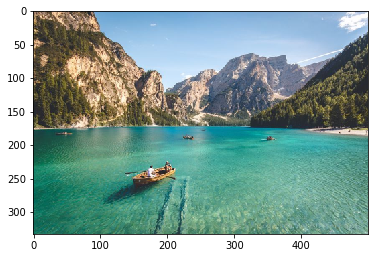

In [57]:
# read the image file and resize it

filename = './test1.jpeg'
im_bgr = cv2.imread(filename)
b,g,r = cv2.split(im_bgr)
im_rgb = cv2.merge([r,g,b])
im_rgb = img_resize(im_rgb, 500)

[row, col, channel] = im_rgb.shape

im = cv2.imread(filename, 0)

im = img_resize(im, 500)
plt.figure(figsize=(6, 6))
plt.imshow(im_rgb)

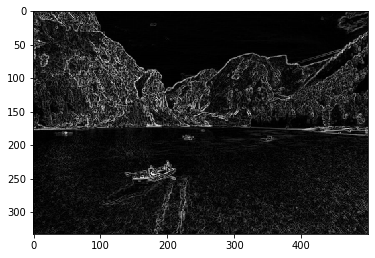

In [58]:
# show energy image

eI1 = compute_importance(im)
plt.figure(figsize=(6, 6))
plt.imshow(eI1, cmap = plt.cm.gray)

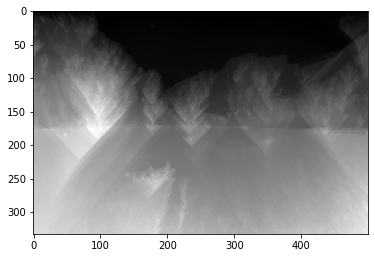

In [59]:
# show accumulation of energy image

M, track = compute_M(eI1)
plt.figure(figsize=(6, 6))
plt.imshow(M, cmap = plt.cm.gray)

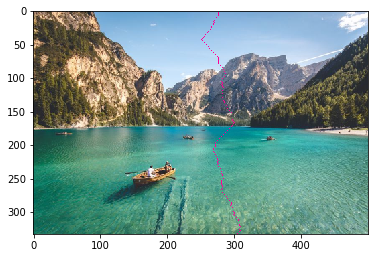

In [61]:
# show energy minimum path

pos = np.argmin(M[row - 1, :])
mask_im = im_rgb.copy()
for i in reversed(range(row)):
    pos = int(track[i, pos])
    mask_im[i, pos] = (255, 0, 150)
plt.figure(figsize=(6, 6))
plt.imshow(mask_im)

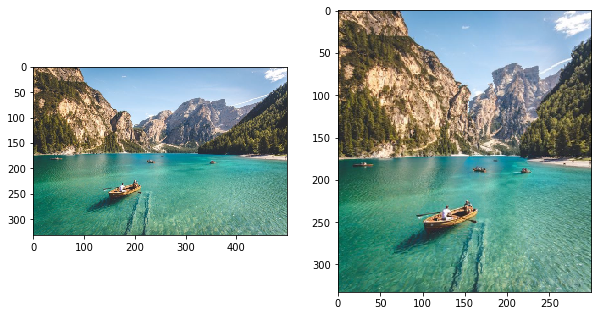

In [68]:
# crop the image

im_crop = crop_image(im_rgb, 320, 300)
plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
plt.imshow(im_rgb)
ax = plt.subplot(122)
plt.imshow(im_crop)
plt.show()

1.040625 1.25
(333, 500, 3)


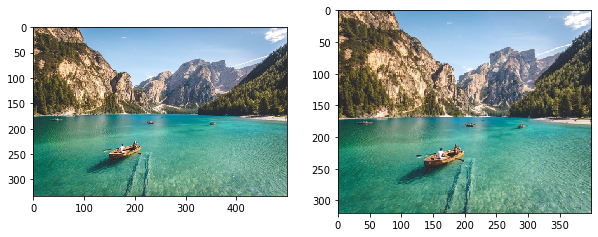

In [70]:
# retarget the image

im_retar = retarget_image(im_rgb, 320, 400)
plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
plt.imshow(im_rgb)
ax = plt.subplot(122)
plt.imshow(im_retar)
plt.show()

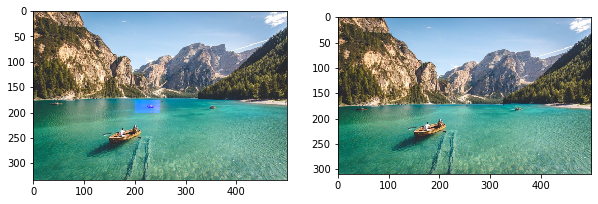

In [71]:
# remove the specified rectangular area

# rect = draw_rect(im_rgb, 350, 358, 270, 310)
# result = remove_rect_horizon(im_rgb, 350, 358, 270, 310)
rect = draw_rect(im_rgb, 175, 200, 200, 250)
result = remove_rect_horizon(im_rgb, 175, 200, 200, 250)
plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
plt.imshow(rect)
ax = plt.subplot(122)
plt.imshow(result)
plt.show()

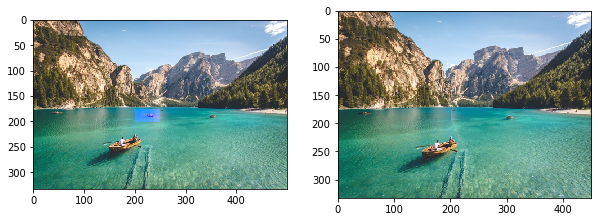

In [74]:
# remove the specified rectangular area

# rect1 = draw_rect(im_rgb, 350, 358, 270, 310)
# result1 = remove_rect(im_rgb, 350, 358, 270, 310)
rect1 = draw_rect(im_rgb, 175, 200, 200, 250)
result1 = remove_rect(im_rgb, 175, 200, 200, 250)
plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
plt.imshow(rect1)
ax = plt.subplot(122)
plt.imshow(result1)
plt.show()

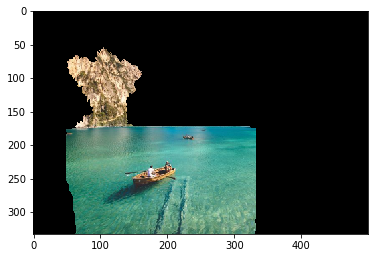

In [75]:
# show the foreground isolated by grab cut

im_cut = im_rgb.copy()
rows, cols = im_cut.shape[0], im_cut.shape[1]
mask = np.zeros(im_cut.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,rows - 50, cols - 50)#划定区域
cv2.grabCut(im_cut,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')#0和2做背景
im_re = im_cut * mask2[:,:,np.newaxis]#使用蒙板来获取前景区域
plt.figure(figsize=(6, 6))
plt.imshow(im_re, cmap = plt.cm.gray)

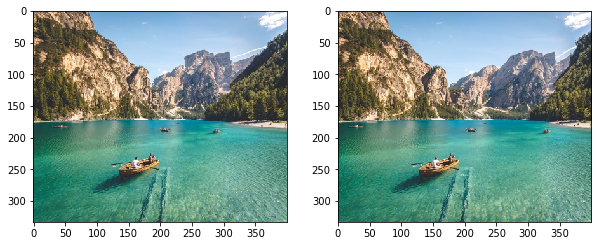

In [76]:
# improved seam carving

im_cc = im_rgb.copy()
for i in range(100):
    im_cc = delete_column(im_cc)

im_bg = im_rgb.copy()
for i in range(100):
    im_bg = delete_bg_column(im_bg)
    
plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
plt.imshow(im_cc)
ax = plt.subplot(122)
plt.imshow(im_bg)
plt.show()

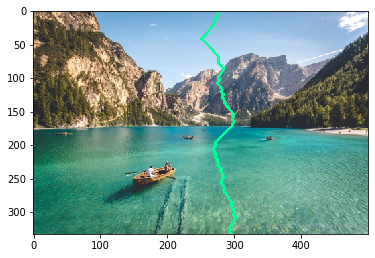

In [77]:
# show multiple path 1

plt.figure(figsize=(6, 6))
m1_im = delete_multi_column(im_rgb, 5, True)

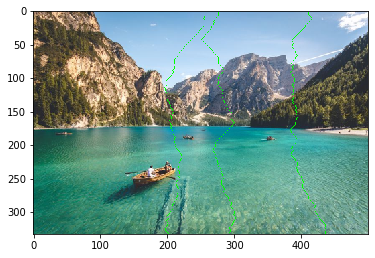

In [78]:
# show multiple path 2

plt.figure(figsize=(6, 6))
m2_im = delete_multi_column2(im_rgb, 3, True)

multi_column1:  32.06568500000003 s
multi_column2:  33.16676099999995 s
single_column:  95.75276299999996 s


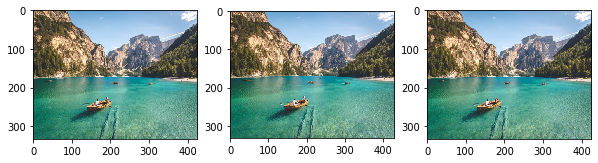

In [79]:
start1 = time.clock()
mc1_im = im_rgb.copy()
for i in range(25):
    mc1_im = delete_multi_column(mc1_im, 3)

start2 = time.clock()
mc2_im = im_rgb.copy()
for i in range(25):
    mc2_im = delete_multi_column2(mc2_im, 3)

start3 = time.clock()
mc3_im = im_rgb.copy()
for i in range(75):
    mc3_im = delete_column(mc3_im)
    
end = time.clock()

print ('multi_column1: ', start2 - start1, 's')
print ('multi_column2: ', start3 - start2, 's')
print ('single_column: ', end - start3, 's')
    
plt.figure(figsize=(10, 10))
ax = plt.subplot(131)
plt.imshow(mc3_im)
ax = plt.subplot(132)
plt.imshow(mc1_im)
ax = plt.subplot(133)
plt.imshow(mc2_im)
plt.show()